# Analyzing m5C patterns in Noc-treated HeLa cells (CPU-based)

---

Author: Jianheng Liu @ Rui Zhang's Lab, SYSU, China

Email: jhfoxliu@gmail.com

Date: Jan, 2022

## Packages

- Python==3.7.8
- numpy==1.20.0
- scipy==1.5.1
- umap-learn==0.5.2
- sklearn==0.23.1
- matplotlib==3.2.2
- seaborn==0.10.1
- hdbscan==0.8.27

## 0. Configure environment

In [1]:
import time
import sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import scipy.stats
import tracemalloc
import umap
import hdbscan
from IPython.display import Image

# for Linux only, load font file
mpl.font_manager.fontManager.addfont("./arial.ttf")

# configure matplotlib
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

tracemalloc.start()


This is a helper function useful for export fasta and motifs.

In [2]:
def extract_fasta_and_draw_motifs(prefix, df, cluster_col="Cluster", filter=None, motif_column=("INFO", "motif_F10"), draw_logos=True):
    print("===============  {} ===============".format(prefix))
    if os.path.isdir("{}".format(prefix)) == False:
        os.mkdir("./{}".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    else:
        os.system("rm -r ./{}/*".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    if filter is not None:
        df = df[df[filter] == True].copy()
    clusters = set(df[cluster_col].tolist())
    for g in clusters:
        subdf = df[df[cluster_col] == g]
        with open("./{}/fasta/cluster_{}.fa".format(prefix, g), "w") as output:
            N = 0
            for idx, row in subdf.iterrows():
                output.write(">{}\n{}\n".format(idx, row[motif_column].replace("T", "U")))  # to RNA bases
                N += 1
            print("Cluster #{}: {}".format(g, N))
    if draw_logos == True:
        for g in clusters:
            os.system("weblogo -A rna -D fasta -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_png/cluster_{g}.png".format(prefix=prefix, g=g))

            os.system("weblogo -A rna -D fasta -F pdf -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq_png/cluster_{g}.png".format(prefix=prefix, g=g)) 
            
            os.system("weblogo -A rna -D fasta -X no -Y no -P \"\" -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_no_axis/cluster_{g}.pdf".format(prefix=prefix, g=g))

In [3]:
def show_logos(prefix, names=None):
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        plt.figure()
        image = plt.imread(prefix+"/"+img)
        plt.imshow(image)
        plt.axis("off")

This is a helper function useful for MEME analysis.

In [4]:
def run_meme(prefix, fasta_prefix, fn, mode=["streme", "meme", "ce", "cd"], nmotifs=5):
    if os.path.isdir("./{}/meme".format(prefix)) == False:
        os.mkdir("./{}/meme".format(prefix))
    else:
        os.system("rm -r ./{}/meme/*".format(prefix))
    for m in mode:
        if m == "meme":
            # Normal mode
            print("Runing MEME...")
            os.system("meme -rna -nmotifs {nmotifs} -minw 5 -maxw 10 -oc ./{prefix}/meme/{out}_meme ./{fasta_prefix}/{fn}".format(fn=fn, prefix=prefix, nmotifs=nmotifs, fasta_prefix=fasta_prefix, out=fn.strip(".fa")))
        elif m == "ce":
            # CE mode
            print("Runing MEME in CE mode...")
            os.system("meme -rna -objfun ce -cefrac 0.1 -nmotifs {nmotifs} -minw 5 -maxw 10 -oc ./{prefix}/meme/{out}_meme_ce ./{fasta_prefix}/{fn}".format(fn=fn, prefix=prefix, nmotifs=nmotifs, fasta_prefix=fasta_prefix, out=fn.strip(".fa")))
        elif m == "cd":
            # CE mode
            print("Runing MEME in CD mode...")
            os.system("meme -rna -objfun cd -cefrac 0.1 -nmotifs {nmotifs} -minw 5 -maxw 10 -oc ./{prefix}/meme/{out}_meme_cd ./{fasta_prefix}/{fn}".format(fn=fn, prefix=prefix, nmotifs=nmotifs, fasta_prefix=fasta_prefix, out=fn.strip(".fa")))
        elif m == "streme":
            print("Runing STREME")
            os.system("streme --rna --pvt 0.05 -nmotifs {nmotifs} --minw 5 --maxw 10 --objfun cd --oc ./{prefix}/meme/{out}_streme --p ./{fasta_prefix}/{fn}".format(fn=fn, prefix=prefix, fasta_prefix=fasta_prefix, nmotifs=nmotifs, out=fn.strip(".fa")))

In [5]:
def show_logos_cols(prefix, names=None, cols=3, figsize=(8,8), auto_size=True):
    file_list = []
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        file_list.append(img)
    
    file_list_format = []
    for i in file_list:
        id = int(i.replace("cluster_", "").replace(".png", ""))
        file_list_format.append((i, id))
    file_list_format = sorted(file_list_format, key=lambda x:x[1]) 
    
    if len(file_list_format) % cols == 0:
        rows = len(file_list_format) // cols
    else:
        rows = len(file_list_format) // cols + 1
    if auto_size == False:
        figsize = figsize
    else:
        width = 4 * cols
        height = 1.5 * rows
        figsize = (width, height)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax, image in zip(*[axes.reshape(-1), file_list_format]):
        fn, id = image
        img = plt.imread(prefix+"/"+fn)
        _ = ax.imshow(img)
        ax.set_title("cluster_{}".format(id))
    for ax in axes.reshape(-1):
        ax.axis("off")
    plt.tight_layout()

## 1. Load data and Hot-hot encoded

In [6]:
df = pd.read_csv("./HeLa_Noc_NSUNs.motif.F10.csv", index_col=[0,1,2], header=[0,1])

enc = OneHotEncoder(dtype=np.int8)
enc.fit([[i] for i in "ATCGN"])

def onehot_enc(row):
    seq = [[i] for i in row[("INFO", "motif_F10")].upper()]
    return enc.transform(seq).toarray().reshape(-1)

onehot_input = []
for idx, row in df.iterrows():
    onehot_input.append(onehot_enc(row))
onehot_input = np.array(onehot_input)

## 2. Dimensional reduction wit UMAP

In [7]:
def UMAP(onehot_input, df, min_dist=0.01, n_neighbors=20, densmap=False):
    df = df.copy()
    # this should takes ~20 sec   
    print("UMAP")
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = umap.UMAP(init="random", random_state=42, n_components=2, min_dist=0.01, n_neighbors=20, verbose=True, densmap=densmap)
    umap_output = model.fit_transform(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    
    print("UMAP time: {} sec".format(time1))
    print("UMAP RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = umap_output[:, 0]
    df["Y"] = umap_output[:, 1]
    
    del model
    return time1, mem, df

In [8]:
_, _, df_UMAP = UMAP(onehot_input, df)

UMAP
UMAP(init='random', min_dist=0.01, n_neighbors=20, random_state=42, verbose=True)
Thu Jan 20 22:13:19 2022 Construct fuzzy simplicial set
Thu Jan 20 22:13:19 2022 Finding Nearest Neighbors
Thu Jan 20 22:13:19 2022 Building RP forest with 11 trees
Thu Jan 20 22:13:20 2022 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	Stopping threshold met -- exiting after 6 iterations
Thu Jan 20 22:16:48 2022 Finished Nearest Neighbor Search
Thu Jan 20 22:16:52 2022 Construct embedding



Thu Jan 20 22:17:08 2022 Finished embedding
UMAP time: 228.67556285858154 sec
UMAP RAM: 95.27540874481201 MB



**We also try densmap=True in this notebook**

In [9]:
_, _, df_densUMAP = UMAP(onehot_input, df, densmap=True)

UMAP
UMAP(densmap=True, init='random', min_dist=0.01, n_neighbors=20, random_state=42, verbose=True)
Thu Jan 20 22:17:08 2022 Construct fuzzy simplicial set
Thu Jan 20 22:17:08 2022 Finding Nearest Neighbors
Thu Jan 20 22:17:08 2022 Building RP forest with 11 trees
Thu Jan 20 22:17:09 2022 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	Stopping threshold met -- exiting after 6 iterations
Thu Jan 20 22:17:12 2022 Finished Nearest Neighbor Search
Thu Jan 20 22:17:12 2022 Construct embedding
Thu Jan 20 22:17:13 2022 Computing original densities



Thu Jan 20 22:18:16 2022 Finished embedding
UMAP time: 67.73402881622314 sec
UMAP RAM: 108.19195652008057 MB



**For comparison, we also try PCA**

In [10]:
def PCA(onehot_input, df):
    from sklearn import decomposition
    df = df.copy()
    
    print("PCA:")
    n_components= 10
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = decomposition.PCA(n_components=n_components, random_state=42)
    model.fit(onehot_input)
    pca_output = model.transform(onehot_input)
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.

    print("PCA explained variance percentages:")
    print(model.explained_variance_ratio_ * 100)
    print("PCA time: {} sec".format(time1))
    print("PCA RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = pca_output[:, 0]
    df["Y"] = pca_output[:, 1]
    del model
    return time1, mem, df

In [11]:
_, _, df_PCA = PCA(onehot_input, df)

PCA:
PCA explained variance percentages:
[3.69506401 3.47623976 2.88521711 2.79564605 2.66267084 2.63628024
 2.51402389 2.50435651 2.43704037 2.42142221]
PCA time: 0.3241448402404785 sec
PCA RAM: 108.85458946228027 MB



## 3. Cluster sites with HDBSCAN

In [12]:
def cluster_HDBSCAN_softclustering(df, min_cluster_size=100, min_samples=5, cluster_selection_epsilon=0.0, cluster_selection_method='eom', core_dist_n_jobs=4, prediction_data=True):
    # use multi-code here
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon, cluster_selection_method=cluster_selection_method, core_dist_n_jobs=core_dist_n_jobs, prediction_data=prediction_data)
    yhat = model.fit(X)
    
    soft_clusters = hdbscan.all_points_membership_vectors(yhat)
    labels = [np.argmax(x) for x in soft_clusters] 
    # labels = yhat.labels_
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    df["Cluster"] = [i+1 if i > -1 else -1 for i in labels ]  # re-number lables to make it human-readable
    
    print("HDBSCAN soft clustering time: {} sec".format(time1))
    print("HDBSCAN soft clustering RAM: {} Mb".format(mem))
    print("HDBSCAN cluster number: {}".format(df["Cluster"].max()))
    print("==================================================")
    # check cluster number
    print(df.groupby("Cluster")["Cluster"].count())
    return time1, mem, df, model

In [13]:
_, _, df_HDBSCAN, HDBSCAN_model = cluster_HDBSCAN_softclustering(df_UMAP)

HDBSCAN soft clustering time: 1.6977756023406982 sec
HDBSCAN soft clustering RAM: 104.43278121948242 Mb
HDBSCAN cluster number: 3
Cluster
1      495
2      414
3    11775
Name: Cluster, dtype: int64


In [14]:
tracemalloc.stop()

## 3.1 Draw single_linkage_tree of HDBSCAN (optional, slow)

Sometimes, the size of single linkage tree is too big for us to draw. Skip in this analysis.

In [15]:
# skipped
# fig, ax = plt.subplots()
# HDBSCAN_model.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
# plt.savefig("HDBSCAN_single_linkage_tree.pdf")

### 3.2 Draw condensed_tree of HDBSCAN (optional, suggested)

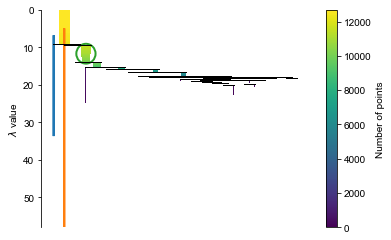

In [16]:
fig, ax = plt.subplots()
HDBSCAN_model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.savefig("HDBSCAN_condensed_tree.pdf")

###  3.3 We also cluster DensMAP result

In [17]:
_, _, df_HDBSCAN_dens, _ = cluster_HDBSCAN_softclustering(df_densUMAP)

HDBSCAN soft clustering time: 0.7721922397613525 sec
HDBSCAN soft clustering RAM: 0.0 Mb
HDBSCAN cluster number: 3
Cluster
1      408
2      753
3    11523
Name: Cluster, dtype: int64


### 3.4 And PCA

In [18]:
_, _, df_HDBSCAN_PCA, _ = cluster_HDBSCAN_softclustering(df_PCA)

HDBSCAN soft clustering time: 0.7665605545043945 sec
HDBSCAN soft clustering RAM: 0.0 Mb
HDBSCAN cluster number: 3
Cluster
1    1396
2    9629
3    1659
Name: Cluster, dtype: int64


## 4. Draw figure

In [19]:
def draw_clusters(ax, df, fn):
    clusters = set(df["Cluster"].tolist())

    for i in clusters:
        subdf = df[df["Cluster"]==i]
        if i == -1:
            ax.scatter(subdf["X"], subdf["Y"], s=1, c="lightgray", lw=None, label=i)
        else:
            ax.scatter(subdf["X"], subdf["Y"], s=1, alpha=1, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=9) # , size=13

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
    
    df.to_csv("{}".format(fn))

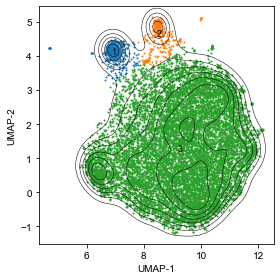

In [20]:
fig, ax = plt.subplots(1, figsize=(4,4))    
draw_clusters(ax, df_HDBSCAN, "HeLa_Noc_NSUNs.motif.F10.clustered.eom.csv")
plt.tight_layout()

plt.savefig("HeLa_Noc.eom.pdf")

### Why DensMAP is not recommended in some cases

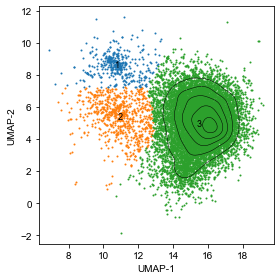

In [21]:
fig, ax = plt.subplots(1, figsize=(4,4))    
draw_clusters(ax, df_HDBSCAN_dens, "HeLa_Noc_NSUNs.motif.F10.clustered.DensMAP.csv")
plt.tight_layout()

plt.savefig("HeLa_Noc.eom.DensMAP.pdf")

In [22]:
extract_fasta_and_draw_motifs("HeLa_Noc_DensMap", df_HDBSCAN_dens)

===============  HeLa_Noc_DensMap ===============
Cluster #1: 408
Cluster #2: 753
Cluster #3: 11523


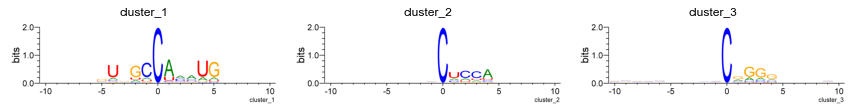

In [23]:
show_logos_cols("./HeLa_Noc_DensMap/logos_bits_png/", cols=3)

Here is a small cluster around (14, 1). Compared with UMAP, DensMAP make what we want more condensed with cluster \#3. Meanwwhile, cluster \#1 and cluster \#2 get closer to each other.

### And why PCA is not a good idea, neither

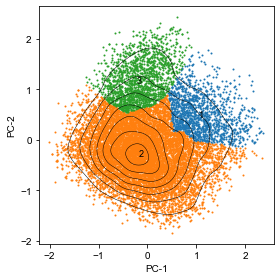

In [24]:
fig, ax = plt.subplots(1, figsize=(4,4))    
draw_clusters(ax, df_HDBSCAN_PCA, "HeLa_Noc_NSUNs.motif.F10.clustered.PCA.csv")
ax.set_xlabel("PC-1")
ax.set_ylabel("PC-2")
plt.tight_layout()
plt.savefig("HeLa_Noc.eom.PCA.pdf")

In [25]:
extract_fasta_and_draw_motifs("HeLa_Noc_PCA", df_HDBSCAN_PCA)

===============  HeLa_Noc_PCA ===============
Cluster #1: 1396
Cluster #2: 9629
Cluster #3: 1659


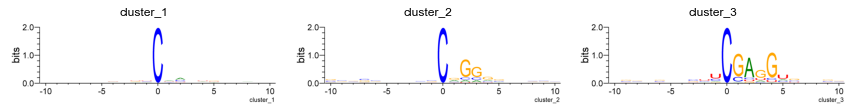

In [26]:
show_logos_cols("./HeLa_Noc_PCA/logos_bits_png/", cols=3)

## 5. Split of cluster \#3

Let's go back to UMAP.

Now we found that except for the major part of cluster \#3, there is another core in the big cluser.We can observe this from the condensed tree. However, these two clusters are too close for 'eom' method. To extract this we can try 'leaf' methods in HDBSCAN.

### 5.1 Use leaf clustering strategy to seperate sub-clusters in cluster \#3

In [27]:
def subcluster_HDBSCAN_leaf_softcluster(df, target=None):
    # use multi-code here
    df = df.copy()
    max_cluster_id = df["Cluster"].max()
    
    df1 = df[df["Cluster"]==target].copy()
    
    X = np.stack([df1["X"], df1["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=50, cluster_selection_method='leaf', core_dist_n_jobs=4, prediction_data=True)
    yhat = model.fit(X)
    
    soft_clusters = hdbscan.all_points_membership_vectors(yhat)
    labels = [np.argmax(x) for x in soft_clusters] 
    # labels = yhat.labels_
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    df1["Cluster"] = [max_cluster_id + i + 1 for i in labels ]  # re-number lables to make it human-readable
    df.loc[df1.index, "Cluster"] = df1["Cluster"].tolist()
    
    print("HDBSCAN soft clustering time: {} sec".format(time1))
    print("HDBSCAN soft clustering RAM: {} Mb".format(mem))
    print("HDBSCAN cluster number: {}".format(df["Cluster"].max()))
    # print("==================================================")
    # check cluster number
    print(df.groupby("Cluster")["Cluster"].count())
    return time1, mem, df, model

_, _, df_HDBSCAN_2, HDBSCAN_model_2 = subcluster_HDBSCAN_leaf_softcluster(df_HDBSCAN, target=3)

HDBSCAN soft clustering time: 0.9247725009918213 sec
HDBSCAN soft clustering RAM: 0.0 Mb
HDBSCAN cluster number: 17
Cluster
1      495
2      414
4      829
5      940
6      516
7      406
8      435
9     1093
10     916
11     679
12    1037
13    1411
14     821
15     765
16     858
17    1069
Name: Cluster, dtype: int64


### 5.2 Draw figure agian

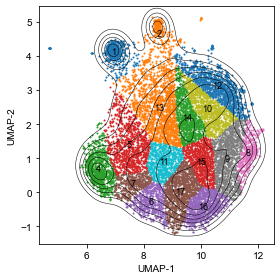

In [28]:
fig, ax = plt.subplots(1, figsize=(4,4))

draw_clusters(ax, df_HDBSCAN_2, "HeLa_Noc_NSUNs.motif.F10.clustered.leaf.csv")
plt.tight_layout()

plt.savefig("HeLa_Noc.leaf.pdf")

### 5.3 Manually merge cluster \#5 - \#18 as cluster \#3, draw figure

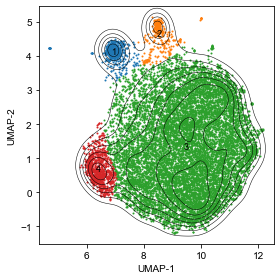

In [29]:
fig, ax = plt.subplots(1, figsize=(4,4))

df_HDBSCAN_2.loc[df_HDBSCAN_2["Cluster"]>4, "Cluster"] = 3
draw_clusters(ax, df_HDBSCAN_2, "HeLa_Noc_NSUNs.motif.F10.clustered.curated.csv")
plt.tight_layout()

plt.savefig("HeLa_Noc.curated.pdf")

## 6. Analyze the m5C level changes in the experiments

### 6.1 Draw pairwise matrix

In [30]:
# define a function for pairwise analysis
def draw_pairwise(df_analysis):   
    def draw_mid_line(x,y,**kws):
        ax = plt.gca()
        ax.set_xlim(-0.05,1.05)
        ax.set_ylim(-0.05,1.05)
        Line1 = Line2D(ax.get_xlim(),ax.get_ylim(),linestyle='--',alpha=1,zorder=0,linewidth=0.8,color="black")
        ax.add_line(Line1)

    def corrfunc(x,y,**kws):
        size = 12
        df1 = x.to_frame(name="X")
        df2 = y.to_frame(name="Y")
        subdf = pd.concat([df1,df2],axis=1)
        subdf = subdf.dropna(how="any",thresh=2)
        ax = plt.gca()
        r, _ = scipy.stats.pearsonr(subdf["X"],subdf["Y"])
        prefix1 = str(x.name).split(" ")[0].split("_")[0]
        prefix2 = str(y.name).split(" ")[0].split("_")[0]
        color = "k"
        ax.annotate("{:.2f}".format(r),
                xy=(.5, .5), xycoords=ax.transAxes,size=size,ha="center",va="center",color=color)

    def draw_scatter(x,y,**kws):
        index1 = set(site_used[site_used[x.name]==True].index.tolist())
        index2 = set(site_used[site_used[y.name]==True].index.tolist())
        comm_idx = list(index1 | index2)
        share = list(index1 & index2)
        df1 = x.to_frame(name="X")
        df2 = y.to_frame(name="Y")
        subdf = pd.concat([df1,df2],axis=1)
        subdf = subdf.dropna(how="any",thresh=2)
        ax = plt.gca()
        prefix1 = str(x.name).split(" ")[0].split("_")[0]
        prefix2 = str(y.name).split(" ")[0].split("_")[0]
        x = subdf["X"]
        y = subdf["Y"]
        ax.scatter(x,y,s=2, lw=0.1, alpha=0.5)

    def draw_hist2d_scatter(x,y, vmax=25,**kws):
        index1 = set(site_used[site_used[x.name]==True].index.tolist())
        index2 = set(site_used[site_used[y.name]==True].index.tolist())
        comm_idx = list(index1 | index2)
        share = list(index1 & index2)
        df1 = x.to_frame(name="X")
        df2 = y.to_frame(name="Y")
        subdf = pd.concat([df1,df2],axis=1)
        ax = plt.gca()
        prefix1 = str(x.name).split(" ")[0].split("_")[0]
        prefix2 = str(y.name).split(" ")[0].split("_")[0]
        subdf = subdf.dropna()
        x = subdf["X"]
        y = subdf["Y"]
        h,xedg,yedg,img = ax.hist2d(x,y,range=[[0,1],[0,1]],bins=[50,50],cmin=1,vmax=vmax,cmap="jet")
    
    def draw_labels_mid(x,**kws):
        ax = plt.gca()
        text = columns.pop().replace("_", " ")
        ax.annotate("%s" % text,
                    xy=(.5, .5), xycoords=ax.transAxes,size=12,ha="center",va="center")

    # extract data
    cov = df_analysis.xs("coverage",axis=1,level=1).copy()
    level = df_analysis.xs("m5C level",axis=1,level=1).copy()
    site_used = df_analysis.xs("passed",axis=1,level=1).copy()

    # mask low coverage cells
    cov[cov<20] = -1000
    cov[cov>=20] = 0
    
    DF = cov + level
    DF[DF<0] = np.nan
    columns = list(DF)[::-1]
    
    g = sns.PairGrid(DF,despine=False,dropna=True,size=0.8)
    g.fig.set_size_inches(8,8)
    # we use 2D-hist combined with scatter
    # g = g.map_lower(draw_scatter)
    g = g.map_lower(draw_hist2d_scatter)
    g = g.map_lower(draw_mid_line)
    g = g.map_upper(corrfunc)
    g = g.map_diag(draw_labels_mid)
    
    rows,cols = g.axes.shape
    for i in range(0,rows):
        for j in range(0,cols):
            ax = g.axes[i][j]
            ax.xaxis.set_ticks_position('none')
            ax.yaxis.set_ticks_position('none')
            if i == 0:
                if j != 0:
                    ax.xaxis.set_ticks_position('top')
            if j == 0:
                if i != 0:
                    ax.yaxis.set_ticks_position('left')
            if i == rows-1:
                if j != cols - 1:
                    ax.xaxis.set_ticks_position('bottom')
            if j == cols-1:
                if i != rows - 1:
                    ax.yaxis.set_ticks_position('right')
            # common settings
            ax.set_xlabel("")
            ax.set_ylabel("")

            ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))

            ax.xaxis.set_tick_params(rotation=90)
            
    g.axes[0][0].set_yticklabels([])
    
    g.axes[0][-1].set_xticks([])
    g.axes[0][-1].set_yticks([])
    g.axes[0][-1].set_xticklabels([])
    g.axes[0][-1].set_yticklabels([])
    
    g.axes[-1][-1].set_xticklabels([])
    
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.075, wspace=0.075)

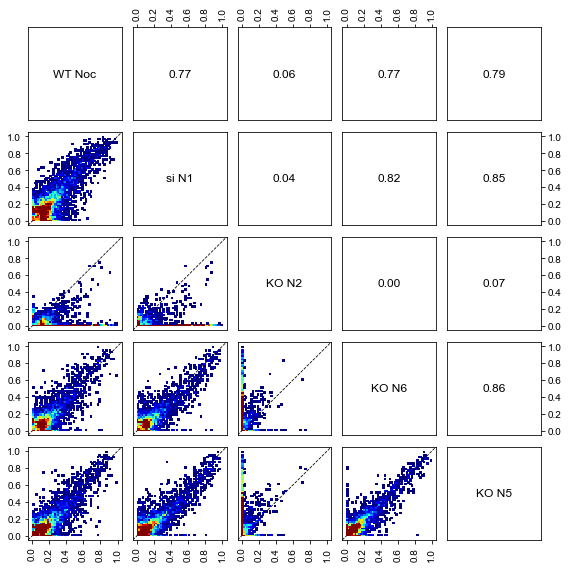

In [31]:
import warnings
warnings.filterwarnings('ignore')
draw_pairwise(df_HDBSCAN_2[["WT_Noc", "si_N1", "KO_N2", "KO_N6", "KO_N5"]].copy())
plt.tight_layout()
plt.savefig("HeLa_Noc_pairwise.pdf")

### 6.2 Compare methylation levels between Noc-treated WT cells and experimental groups

In [32]:
def draw_cluster_level_changes(ax, df, X="WT_Noc", Y=None, cluster=None):
    def fisher_exact(row, X, Y):
        try:
            C_1 = row[(X, "C count")]
            cov_1 = row[(X, "coverage")]
            C_2 = row[(Y, "C count")]
            cov_2 = row[(Y, "coverage")]
            odds,pvalue = scipy.stats.fisher_exact([[C_1, C_2], [cov_1-C_1, cov_2-C_2]], alternative="greater")
        except ValueError:
            pvalue = 1.0
        return pvalue
    df_analysis = df[(df[(X, "coverage")]>=20) & (df[(Y, "coverage")]>=20) & (df[(X, "passed")]==True) ].copy()
    df_len = df_analysis.shape[0]
    
    ax.set_aspect('equal', 'box')
    
    df1 = df_analysis[df_analysis["Cluster"] != cluster].copy()
    df2 = df_analysis[df_analysis["Cluster"] == cluster].copy()
    df2["pvalue"] = df2.apply(lambda x: fisher_exact(x, X, Y), axis=1)
    
    
    scatter1 = ax.scatter(x=df1[(X,"m5C level")],y=df1[(Y,"m5C level")], c="lightgray",alpha=1.0,s=2)
    # scatter2 = ax.scatter(x=df2[(X,"m5C level")],y=df2[(Y,"m5C level")], c="navy",alpha=1.0,s=2)
    scatter2 = ax.scatter(x=df2[(X,"m5C level")],y=df2[(Y,"m5C level")], c=df2["pvalue"], alpha=1.0, s=2, norm=LogNorm(vmin=0.001, vmax=1.0))
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.set_xlim(-0.02,1.02)
    ax.set_ylim(-0.02,1.02)
    ax.set_xlabel(X)
    ax.set_ylabel(Y)
    ax.set_title("Cluster #{}".format(cluster))

    sig = df2[df2["pvalue"]<0.05].shape[0]
    text = "Sites={}\np<0.05={} ({:.1%})".format(df2.shape[0], sig, sig/(df2.shape[0]+0.0))
    ax.annotate(text, xy=(0.05,0.95), xycoords="axes fraction", ha="left", va="top")

    return scatter2

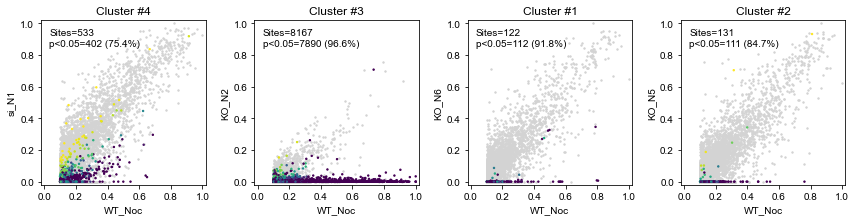

In [33]:
fig, axes = plt.subplots(1, 4, figsize=(12,3))
for ax, sample, cluster in zip(*[axes, ["si_N1","KO_N2", "KO_N6", "KO_N5"], [4, 3, 1, 2]]):
    scatter2 = draw_cluster_level_changes(ax, df_HDBSCAN_2, Y=sample, cluster=cluster)
# plt.colorbar(scatter2, ax=axes[-1], shrink =1. )
plt.tight_layout()
plt.savefig("HeLa_Noc_vs_exp.pdf")

## 7. Motif analysis

### 7.1 Extract fasta and draw motifs with Weblogo

Here we use a automatic function to finish fasta extraction and motif drawing.

In [34]:
extract_fasta_and_draw_motifs("HeLa_Noc", df_HDBSCAN_2)

===============  HeLa_Noc ===============
Cluster #1: 495
Cluster #2: 414
Cluster #3: 10946
Cluster #4: 829


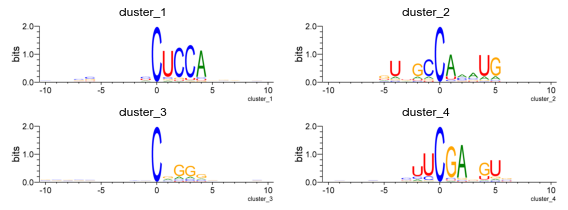

In [35]:
show_logos_cols("./HeLa_Noc/logos_bits_png/", cols=2)

### 7.2 Draw MEME motifs (long time)

In [36]:
# run meme with all fasta output
# skipped here
#for fn in os.listdir("./HeLa_Noc/fasta/"):
#    run_meme("HeLa_Noc", "./HeLa_Noc/fasta/", fn, mode=["streme", "meme", "ce", "cd"], nmotifs=2)

In [37]:
# check all sequences
# skipped here
#os.system("cat ./HeLa_Noc/fasta/*fa > ./HeLa_Noc/meme/merged.fa")

# STREME
#!streme --rna --pvt 0.05 -nmotifs 10 --minw 5 --maxw 10 --objfun cd --oc ./HeLa_Noc/meme/merged_streme -p ./HeLa_Noc/meme/merged.fa

# Normal mode
#!meme -rna -nmotifs 5 -minw 5 -maxw 10 -oc ./HeLa_Noc/meme/merged_meme ./HeLa_Noc/meme/merged.fa

# CE mode
#!meme -rna -objfun ce -nmotifs 5 -cefrac 0.1 -minw 5 -maxw 10 -oc ./HeLa_Noc/meme/merged_meme_ce ./HeLa_Noc/meme/merged.fa

# CD mode
#!meme -rna -objfun cd -nmotifs 5 -minw 5 -maxw 10 -oc ./HeLa_Noc/meme/merged_meme_cd ./HeLa_Noc/meme/merged.fa